<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/EVA4P2_S5_HPE_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! nvidia-smi

Sat Sep 26 09:55:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
CONFIG_FILE_DIR    = f'/content/gdrive/My Drive/EVA4P2_HPE_S5_Training/256x256_d256x3_adam_lr1e-3.yaml'
IMAGE_FILE         = f'/content/gdrive/My Drive/EVA4P2_HPE_S5_Training/Messi_Kick.jpg'
QUANTIZED_FILE_DIR = f'/content/gdrive/My Drive/EVA4P2_HPE_S5_Training/quantized_model_1.onnx'
OUTPUT_IMAGE_SHAPE = (256, 256)

In [7]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 30kB/s 
     |████████████████████████████████| 6.5MB 64.6MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [8]:
import os
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re
from operator import itemgetter
!pip install onnxruntime
import onnxruntime
print('Pytorch version:', torch.__version__)

     |████████████████████████████████| 4.4MB 4.8MB/s 
Pytorch version: 1.5.1+cu92


In [9]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

Cloning into 'Deep_Learning_EVA4_Phase2'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1165 (delta 0), reused 0 (delta 0), pack-reused 1160
Receiving objects: 100% (1165/1165), 176.66 MiB | 37.39 MiB/s, done.
Resolving deltas: 100% (612/612), done.
Checking out files: 100% (202/202), done.


In [10]:
%cd '/content/Deep_Learning_EVA4_Phase2/S5_Human_Pose_Estimation'
! ls

/content/Deep_Learning_EVA4_Phase2/S5_Human_Pose_Estimation
AWS_Deploy  models  pose.jpg  README.md  src_config  utils


In [11]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S5_Human_Pose_Estimation/')
import models 
import utils
import src_config 
from models.pose_resnet import get_pose_net
from src_config.config import config
from src_config.config import update_config

In [12]:
#config.TEST.FLIP_TEST  = True
MODEL_FILE = f'/content/gdrive/My Drive/EVA4P2_HPE_S5_Training/pose_resnet_50_256x256.pth.tar'
update_config(CONFIG_FILE_DIR)
model = get_pose_net(config, is_train=False)
model.load_state_dict(torch.load(MODEL_FILE, map_location=torch.device('cpu')))
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
toTensor = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize(mean, std)])

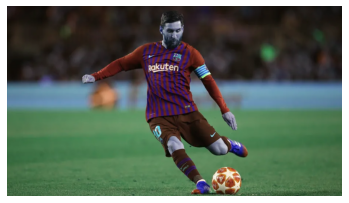

In [13]:
img = cv2.imread(IMAGE_FILE, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
plt.imshow(img)
plt.axis('off')
plt.grid(None)

### Load Input Image and predict from pose estimation Model

In [14]:
img = cv2.imread(IMAGE_FILE, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
img = cv2.resize(img, (256, 256))
x = toTensor(img).unsqueeze(0)  # This will add a dimension of 1 to fake a batch
with torch.no_grad():
    pred = model.forward(x) 
pred = np.array(pred.detach().squeeze())   # Removes the dimension 1 that we previously used to indicate batch
print(pred.shape, pred.shape[1], pred.shape[2])

(16, 64, 64) 64 64


##### '**draw_points_on_image**' function -> This function deals with drawing white points on the original image. This function passes layers from embedding one-by-one to '**getpoint**' function. Each layer will be having a heatmap corresponing to the human joint which will be highlighted via heatmap. '**getpoint**' will return the (x,y) coordinates of this heatmap. These points are normalized w.r.to output image shape and then added to the rezised image as white dots using cv2.circle method.

In [15]:
def draw_points_on_image(img_wo_points):
    points_list = []
    image = cv2.resize(img_wo_points, OUTPUT_IMAGE_SHAPE)
    w, h  = OUTPUT_IMAGE_SHAPE
    p_w, p_h = pred.shape[1:] 
    i = 1 
    for layer in pred:
        x, y    = getpoint(layer, i)
        norm_x  = (w/p_w)*x
        norm_y  = (h/p_h)*y
        norm_x, norm_y = int(norm_x), int(norm_y)
        points_list.append((norm_x, norm_y))
        cv2.circle(image, (norm_x, norm_y), 2, (255, 255, 255), 2)   # cv2.circle(image, center_coordinates, radius, color, thickness)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        i += 1
    return image    

##### **getpoint** function -> This logic deals with finding x,y coordinates of the predicted heatmap point. As a first step, np array corresponding to the layer passed to the function is **flattened**. Let us say if layer shape is 64x64, then we will get an array having 4096 elements. From this array, **point with maximum value** is selected. This is because this point will be the **brightest** because of heatmap. Let us say 3749th element is brightest from 1st layer. Imagine layer as a 64x64 grid whose width is 64 and height is also 64. Now, we will find y = 3749**//** width = 3749 // 64 = 58. This is because 3749 will appear after 58 rows each of width 64 i.e. 3749 will be 37th element in 59th row. So we will consider 58 (rows traversed) as vertical coordinate aka 'y'. Now we know 37 is the X coordinate. We get this by x = 3749 **%** width i.e. remainder of division by width.

##### **Why division by width** ? This is because we are considering **origin as upper left corner** and progress is read from **left to right** *------>

In [16]:
def getpoint(layer, i):
    height, width = layer.shape
    layer = layer.reshape(-1)   # Flattens the numpy array belonging to layer predicted
    idx  = np.argmax(layer)     # Takes the index of maximum number from flattened array. We are using predicting heatmap
    print(f'Joint {i}   Identified at {idx},   Coordinates - ({idx % width},{idx // width})' )
    return idx % width, idx // width

Joint 1   Identified at 3749,   Coordinates - (37,58)
Joint 2   Identified at 3040,   Coordinates - (32,47)
Joint 3   Identified at 2268,   Coordinates - (28,35)
Joint 4   Identified at 2210,   Coordinates - (34,34)
Joint 5   Identified at 3048,   Coordinates - (40,47)
Joint 6   Identified at 2986,   Coordinates - (42,46)
Joint 7   Identified at 2271,   Coordinates - (31,35)
Joint 8   Identified at 991,   Coordinates - (31,15)
Joint 9   Identified at 863,   Coordinates - (31,13)
Joint 10   Identified at 352,   Coordinates - (32,5)
Joint 11   Identified at 1553,   Coordinates - (17,24)
Joint 12   Identified at 1237,   Coordinates - (21,19)
Joint 13   Identified at 922,   Coordinates - (26,14)
Joint 14   Identified at 995,   Coordinates - (35,15)
Joint 15   Identified at 1639,   Coordinates - (39,25)
Joint 16   Identified at 2281,   Coordinates - (41,35)


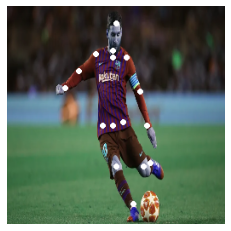

In [17]:
image_with_points = draw_points_on_image(img)
plt.imshow(image_with_points)
plt.axis('off')
plt.grid(None)

In [18]:
threshold      = 0.6           # We will use this threshold to ensure that key-joint we identified via model has pixel value greater than this
out_ht, out_wd = pred.shape[1], pred.shape[2]
out_shape      = (out_ht, out_wd)

##### This is a **list comprehension**. What it essentially does is for each element from **'joints'** list, **sub**stitute the characters **[0-9]+|-'** with '', then **replace** ' ' with - and return the list. eg: '0 - r ankle' will get changed to 'r-ankle'. Note that in HPE method that we are using, we have 16 joints as listed below (hence 16 predictions from model).

In [19]:
joints = ['0 - r ankle',     '1 - r knee',      '2 - r hip', 
          '3 - l hip',       '4 - l knee',      '5 - l ankle', 
          '6 - pelvis',      '7 - thorax',      '8 - upper neck', 
          '9 - head top',    '10 - r wrist',    '11 - r elbow', 
          '12 - r shoulder', '13 - l shoulder', '14 - l elbow', 
          '15 - l wrist']
joints = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in joints]        
joints[0:2]  

['r-ankle', 'r-knee']

##### We are mapping the above joints to body parts - Essentially body is divided into 3 parts for Human Pose Estimation - **Upper** Body, **Lower** Body & **arms**. Please refer github repository to see diagramatic representation.

In [20]:
pose_pairs = [
# UPPER BODY
              [9, 8],
              [8, 7],
              [7, 6],
# LOWER BODY
              [6, 2],
              [2, 1],
              [1, 0],

              [6, 3],
              [3, 4],
              [4, 5],
# ARMS
              [7, 12],
              [12, 11],
              [11, 10],

              [7, 13],
              [13, 14],
              [14, 15]
]

##### **minMaxLoc(input)** -> minVal, maxVal, minLoc, maxLoc
##### **[cv2.minMaxLoc(pose_lyr) for pose_lyr in pose_layers]** -> Will return a list having 16 elements because pose_layers has 16 elements in it. For example, one such element in this list will be (-0.029723331332206726, 1.004146695137024, (14, 55), (37, 58))
##### **operator.itemgetter(n)** constructs a callable that assumes an iterable object (e.g. list, tuple, set) as input, and fetches the n-th element out of it.
##### So **map(itemgetter(1, 3), [cv2.minMaxLoc(pose_lyr) for pose_lyr in pose_layers])** will return 1st and 3rd element from above list i.e. 1.004146695137024 -> maxVal and (37, 58) -> maxLoC. This is because our aim is to find brightest point (key-joint heatmap point) from the supplied prediction layer.
##### Entire thing is wrapped in a **lambda** function which will be called from **get_image_with_points_connected_lines** function.

In [21]:
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_lyr) for pose_lyr in pose_layers])
pose_layers = pred
lst = [cv2.minMaxLoc(pose_lyr) for pose_lyr in pose_layers]
key_points  = list(get_keypoints(pose_layers=pose_layers))
print(lst[0])
print(key_points[0])

(-0.029723331332206726, 1.004146695137024, (14, 55), (37, 58))
(1.004146695137024, (37, 58))


##### **get_image_with_points_connected_lines** -> This function plots the keyjoints based on pose_pairs defined above and connects the keyjoints between them. 

In [22]:
def get_image_with_points_connected_lines():
    image_p = cv2.imread(IMAGE_FILE)
    pose_layers = pred
    key_points  = list(get_keypoints(pose_layers=pose_layers))   # Gets list of keypoints using lambda function
    is_joint_plotted = [False for i in range(len(joints))]       # Creating a list of 'False' flags
    for pose_pair in pose_pairs:
        print(pose_pair)
        from_j, to_j = pose_pair

        from_thr, (from_x_j, from_y_j) = key_points[from_j]
        print('from_j, from_thr, from_x_j, from_y_j:',from_j, from_thr, from_x_j, from_y_j)
        to_thr,   (to_x_j, to_y_j)     = key_points[to_j]
        print('to_j, to_thr, to_x_j, to_y_j:',to_j, to_thr, to_x_j, to_y_j)

        img_height, img_width, _ = image_p.shape
        from_x_j, to_x_j         = from_x_j * (img_width / out_wd), to_x_j * (img_width / out_wd)          # Normalizing X coordinates of connecting line w.r.to output image size
        from_y_j, to_y_j         = from_y_j * (img_height / out_ht), to_y_j * (img_height / out_ht)        # Normalizing Y coordinates of connecting line w.r.to output image size
        from_x_j, to_x_j         = int(from_x_j), int(to_x_j)
        from_y_j, to_y_j         = int(from_y_j), int(to_y_j)

        if from_thr > threshold and not is_joint_plotted[from_j]:       # Checking if maxVal of 'from' keypoint is above threshold, if so plot the point in elliptical shape
            # this is a joint                                           
            # cv2.ellipse(image, centerCoordinates, axesLength, angle, startAngle, endAngle, color [, thickness[, lineType[, shift]]])
            cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
            is_joint_plotted[from_j] = True                 # A joint plotted need not be plotted next time when it appears in pose_pair

        if to_thr > threshold and not is_joint_plotted[to_j]:           # Checking if maxVal of 'to' keypoint is above threshold, if so plot the point in elliptical shape
            # this is a joint
            cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
            is_joint_plotted[to_j] = True

        if from_thr > threshold and to_thr > threshold:                 # Drawing the line connecting 'from' and 'to' keypoints
            # this is a joint connection, plot a line
            cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 2)

        print('is_joint_plotted:',is_joint_plotted)     
         
    return image_p

[9, 8]
from_j, from_thr, from_x_j, from_y_j: 9 0.8754309415817261 32 5
to_j, to_thr, to_x_j, to_y_j: 8 0.9810411334037781 31 13
is_joint_plotted: [False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False]
[8, 7]
from_j, from_thr, from_x_j, from_y_j: 8 0.9810411334037781 31 13
to_j, to_thr, to_x_j, to_y_j: 7 1.1971120834350586 31 15
is_joint_plotted: [False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, False]
[7, 6]
from_j, from_thr, from_x_j, from_y_j: 7 1.1971120834350586 31 15
to_j, to_thr, to_x_j, to_y_j: 6 1.0429394245147705 31 35
is_joint_plotted: [False, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False]
[6, 2]
from_j, from_thr, from_x_j, from_y_j: 6 1.0429394245147705 31 35
to_j, to_thr, to_x_j, to_y_j: 2 1.076210618019104 28 35
is_joint_plotted: [False, False, True, False, False, False, True, True, True, True, False, False, Fals

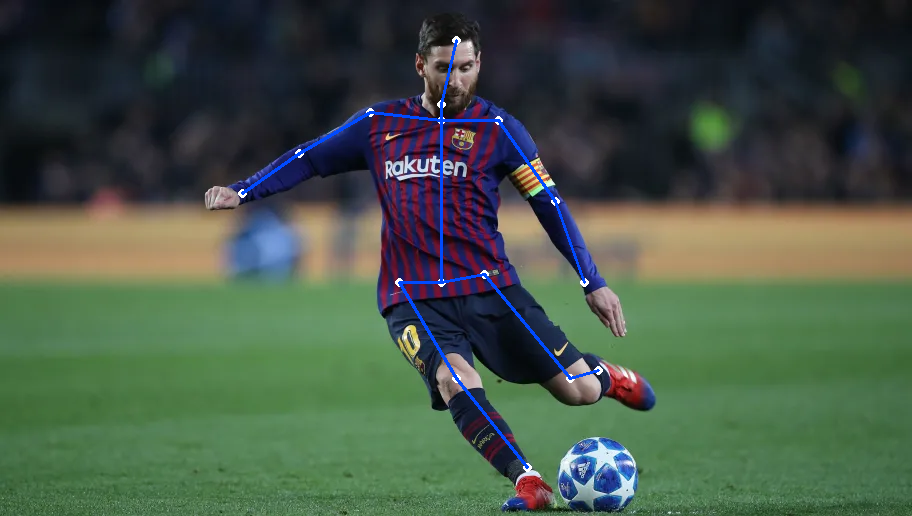

In [23]:
image_p = get_image_with_points_connected_lines()
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))

In [24]:
ort_session = onnxruntime.InferenceSession(QUANTIZED_FILE_DIR)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: np.squeeze(to_numpy(x.unsqueeze(0)), axis=0)}
print(np.squeeze(to_numpy(x.unsqueeze(0)), axis=0).shape)

ort_outs = ort_session.run(None, ort_inputs)    

(1, 3, 256, 256)


In [30]:
print(len(ort_outs))
print((ort_outs[0][0]).shape)
print(type(ort_outs), type(ort_outs[0][0]))

1
(16, 64, 64)
<class 'list'> <class 'numpy.ndarray'>


##### **onnx_get_image_with_points_connected_lines** -> This function is very similar to **get_image_with_points_connected_lines** & plots the keyjoints based on pose_pairs defined above and connects the keyjoints between them. Only difference is pose_layers is derived from onnx output - ort_outs[0][0]

In [31]:
def onnx_get_image_with_points_connected_lines():
    image_p = cv2.imread(IMAGE_FILE)
    pose_layers = ort_outs[0][0]
    key_points = list(get_keypoints(pose_layers=pose_layers))
    is_joint_plotted = [False for i in range(len(joints))]
    for pose_pair in pose_pairs:
        from_j, to_j = pose_pair

        from_thr, (from_x_j, from_y_j) = key_points[from_j]
        to_thr, (to_x_j, to_y_j)       = key_points[to_j]

        img_height, img_width, _       = image_p.shape

        from_x_j, to_x_j               = from_x_j * (img_width / out_wd), to_x_j * (img_width / out_wd)
        from_y_j, to_y_j               = from_y_j * (img_height / out_ht), to_y_j * (img_height / out_ht)
        from_x_j, to_x_j               = int(from_x_j), int(to_x_j)
        from_y_j, to_y_j               = int(from_y_j), int(to_y_j)

        if from_thr > threshold and not is_joint_plotted[from_j]:
            # this is a joint
            cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
            is_joint_plotted[from_j] = True

        if to_thr > threshold and not is_joint_plotted[to_j]:
            # this is a joint
            cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
            is_joint_plotted[to_j] = True

        if from_thr > threshold and to_thr > threshold:
           # this is a joint connection, plot a line
           cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 2)

    return image_p        

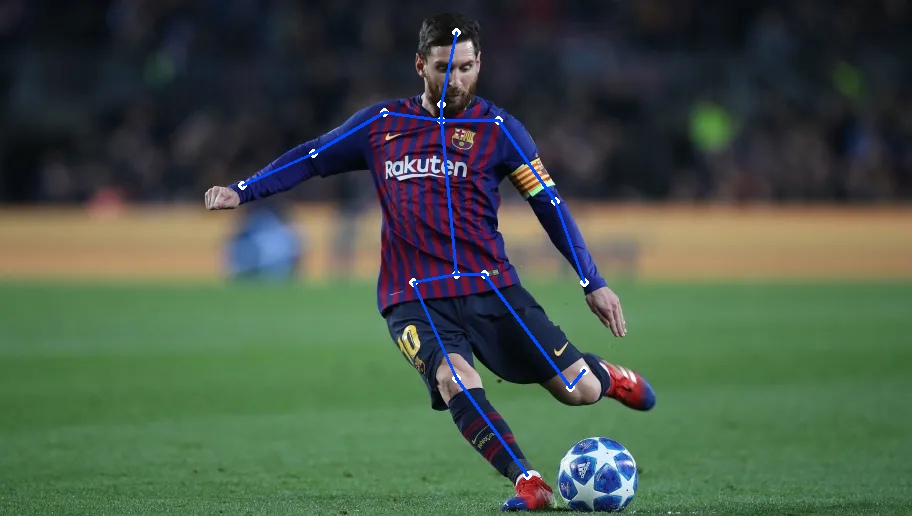

In [33]:
image_p = onnx_get_image_with_points_connected_lines()
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))